In [3]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_percentage_error

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (-2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (-2 * torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def Loss(self, pred, target):
        return torch.sum(torch.pow((target - pred), 2)) / target.size(1)

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def Done_rbf_forward(self, input_data, number):
        rbf_output = self.done_rbf_gaussian(input_data, number)
        pred = torch.mm(self.done_linear_layer_weights[:, number - 1 - self.add_rbf_number: number - 1], rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1 
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)**(1/2) 
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred

    def backward_propagation(self, input_data, radial_output, pred, target):
        error = target - pred  # (1, len_)
        len_ = len(error)

        # sigma update
        deltaSimga = self.rbf_gaussian_derivative_sigma(input_data) * error
        deltaSimga *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaSimga =  torch.sum(deltaSimga, dim=1)

        # center update
        deltaCenter = self.rbf_gaussian_derivative_centers(input_data) * error
        deltaCenter *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter, dim=1)

        # weight update
        # weight_reg = 30000 * self.linear_layer_weights / len(input_data)
        delta_weight = -1 * torch.sum((radial_output * error), dim=1)
        delta_weight = delta_weight.reshape(1, self.add_rbf_number)

        self.linear_layer_weights -= self.lr * delta_weight
        #self.linear_layer_weights -= self.lr * weight_reg

        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)

        self.radial_sigma -= self.lr * deltaSimga.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    self.backward_propagation(input_data, radial_output, pred, self.target)
                    epo_loss = self.Loss(pred, self.target)
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                    self.best_loss = epo_loss.clone().detach()
                    self.best_center = self.radial_layer_centers.clone().detach()
                    self.best_sigma = self.radial_sigma.clone().detach()
                    self.best_weight = self.linear_layer_weights.clone().detach()

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    if epo == 0:
                        print(self.Loss(pred, self.target))
                        self.best_loss = self.Loss(pred, self.target).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()

                    self.backward_propagation(input_data, radial_output, pred, self.target)
                    epo_loss = self.Loss(pred, self.target)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            train_loss = self.Loss(best_pred, self.target)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if train_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(20, 10))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
            else:
                na = 0

In [4]:
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

def rbf_gradient(x, center_list, sigma_list, weight_list):
    rbf_output = (-2 * (x-center_list) / torch.pow(sigma_list,2)) * (torch.exp(-1 * (torch.pow((x - center_list), 2) / (torch.pow(sigma_list, 2)))))
    rbf_grad = torch.mm(weight_list, rbf_output)
    
    return rbf_grad

for i in range(10):
    if i == 0:
        a = np.random.rand(20)
    elif i % 2 == 0:
        a = np.hstack((a, i + np.random.rand(5)))
    else:
        a = np.hstack((a, i + np.random.rand(20)))
    a = np.sort(a)
y = 2*a**3 - 16*a**2 + 2*a -10

target3 = torch.tensor(y, device = device).reshape((1,140))
input_2 = torch.tensor(a, device = device)

def poly_grad(data):
    grad = 6*torch.pow(data, 2) -32*data + 2
    return grad

poly_gr = poly_grad(input_2)

0
249 epoch MSE Loss: 17049.450000350105
499 epoch MSE Loss: 16030.697294149348
749 epoch MSE Loss: 19012.11959468494
999 epoch MSE Loss: 18663.72024361961
train_loss tensor(18662.4727, device='cuda:0', dtype=torch.float64)
best loss :  tensor(18663.7202, device='cuda:0', dtype=torch.float64)


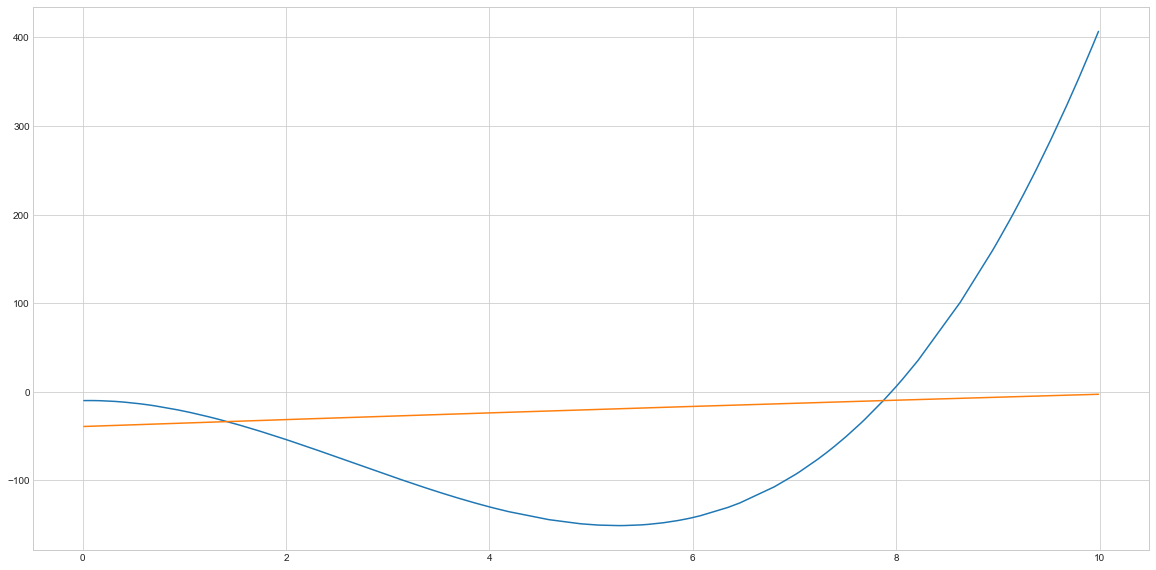

1
tensor(7315447.4656, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 13853.151257034247
train_loss tensor(11630.6627, device='cuda:0', dtype=torch.float64)
best loss :  tensor(11485.4151, device='cuda:0', dtype=torch.float64)


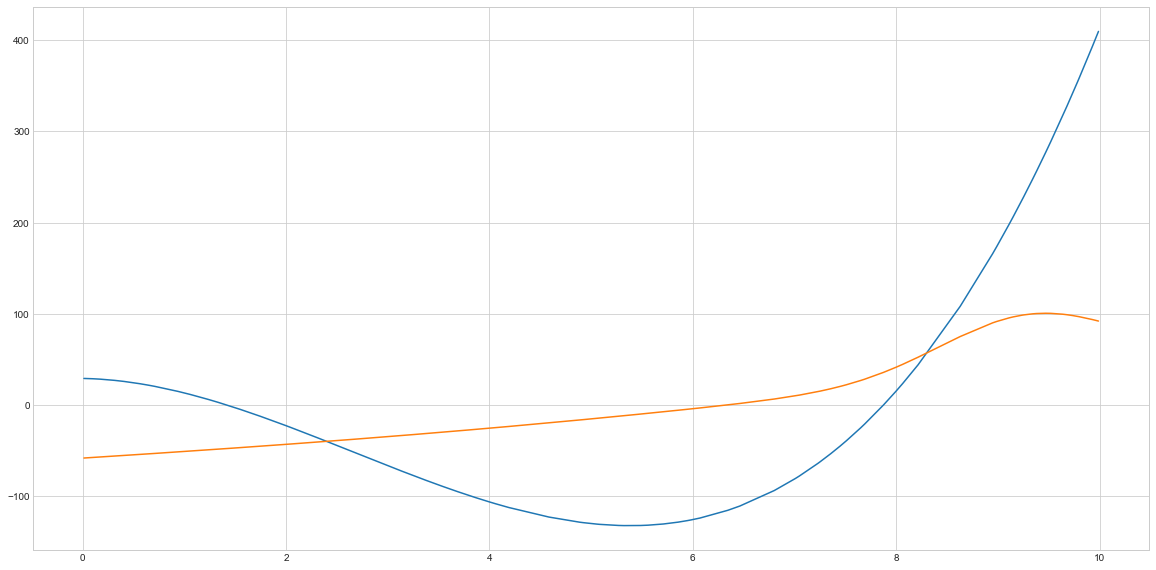

2
tensor(4674412.1165, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 11567.863675016537
train_loss tensor(8953.8366, device='cuda:0', dtype=torch.float64)
best loss :  tensor(7971.8423, device='cuda:0', dtype=torch.float64)


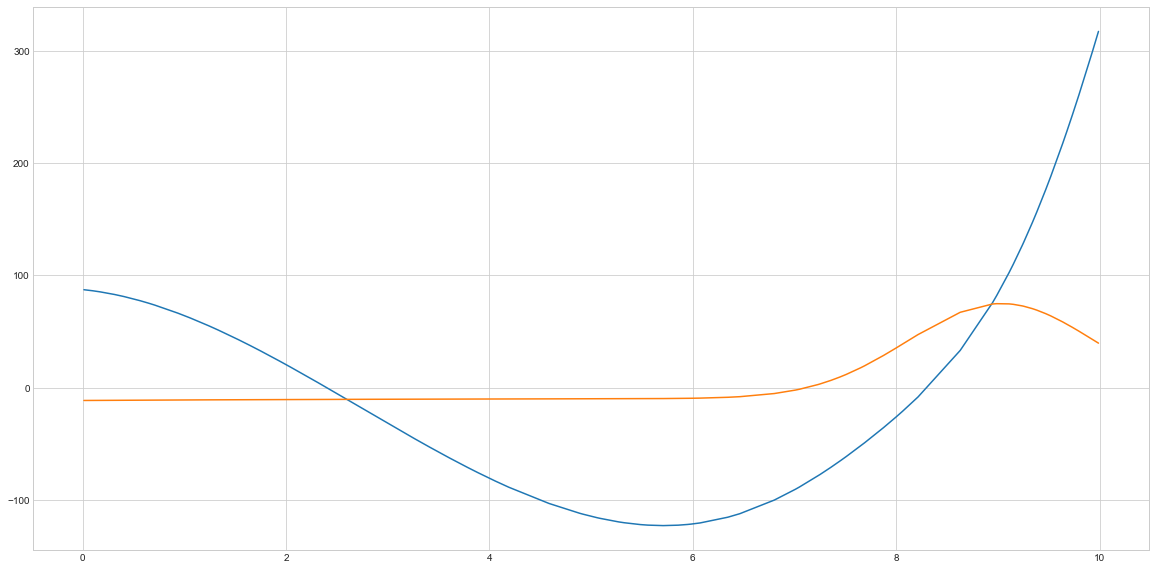

3
tensor(3755330.6083, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 8977.78529626225
train_loss tensor(7311.6089, device='cuda:0', dtype=torch.float64)
best loss :  tensor(7296.0285, device='cuda:0', dtype=torch.float64)


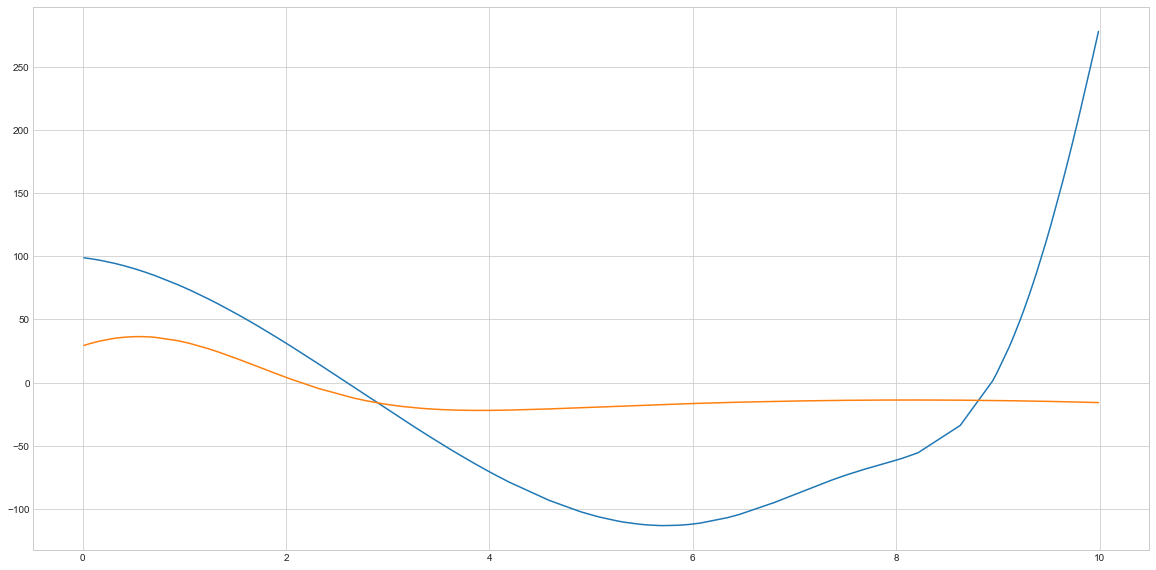

4
tensor(2551697.5175, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 8605.207320608417
train_loss tensor(4841.6166, device='cuda:0', dtype=torch.float64)
best loss :  tensor(3722.6069, device='cuda:0', dtype=torch.float64)


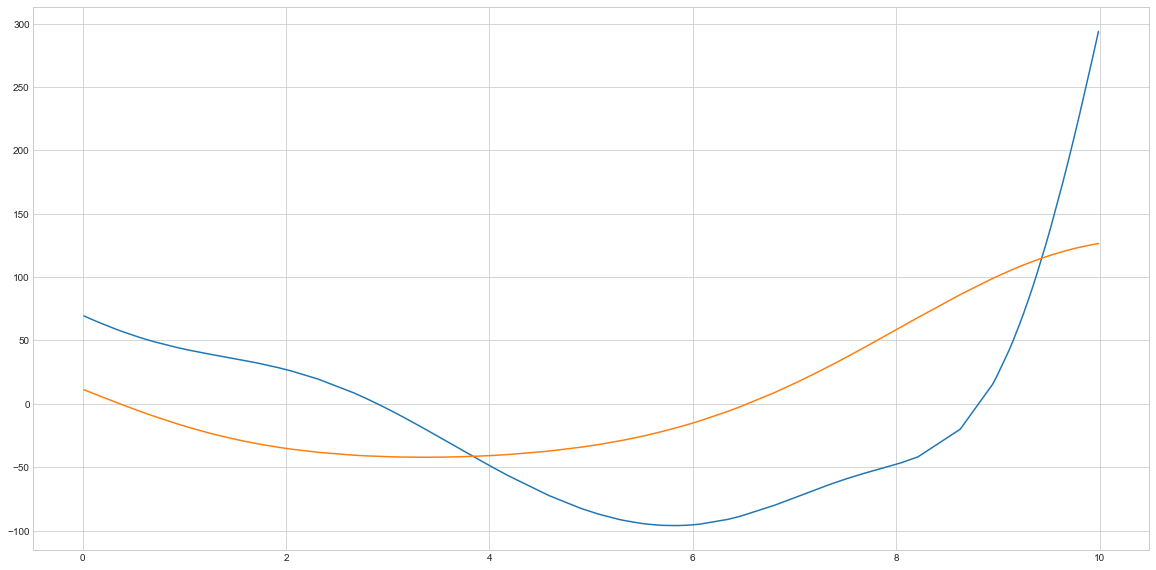

5
tensor(2636331.4456, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 3519.5625041721555
train_loss tensor(2906.8559, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2905.5351, device='cuda:0', dtype=torch.float64)


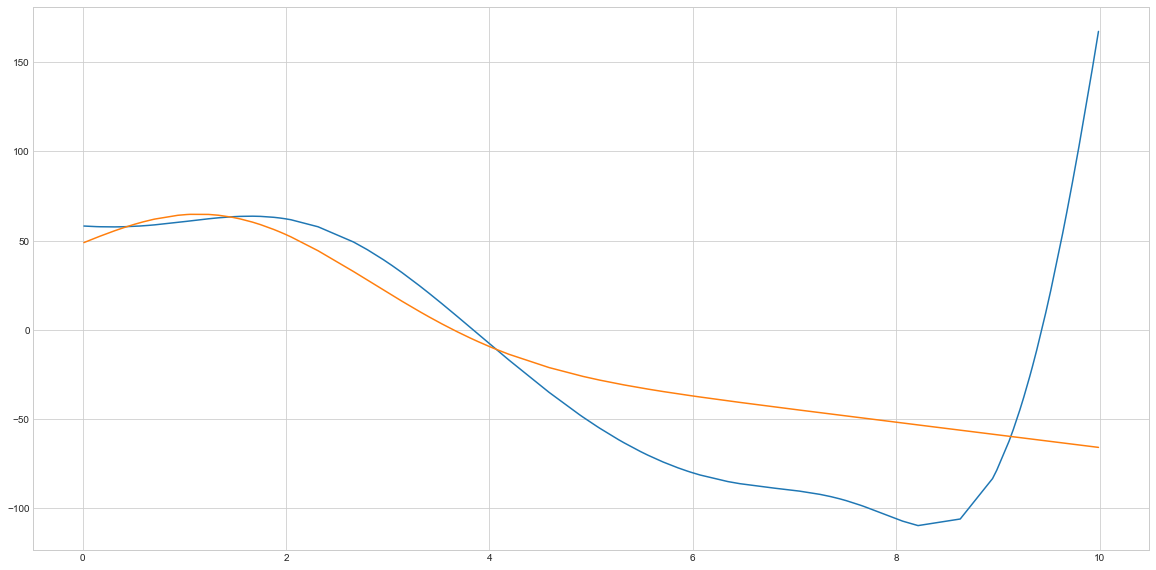

6
tensor(641728.4854, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 849.3458146584715
train_loss tensor(697.6673, device='cuda:0', dtype=torch.float64)
best loss :  tensor(597.3980, device='cuda:0', dtype=torch.float64)


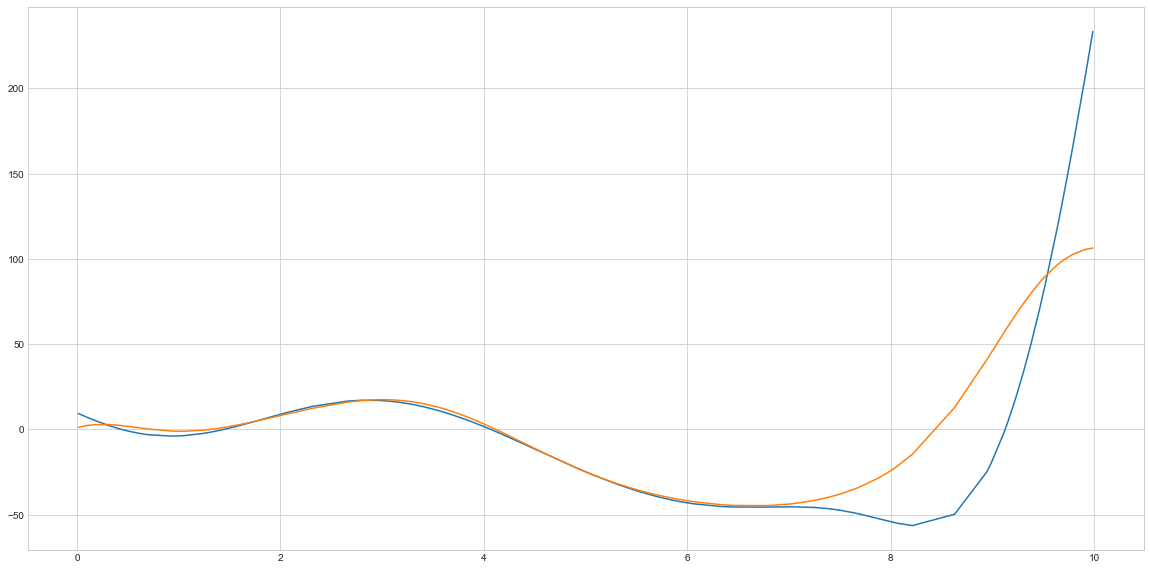

7
tensor(36675.0316, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 454.5013964418006
train_loss tensor(324.8096, device='cuda:0', dtype=torch.float64)
best loss :  tensor(293.8145, device='cuda:0', dtype=torch.float64)


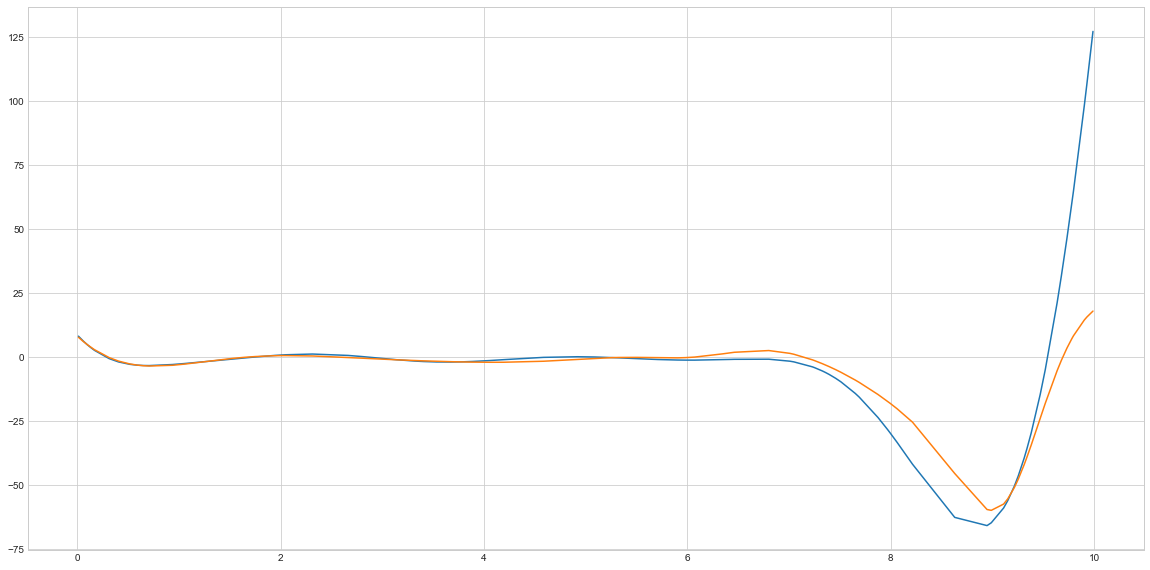

8
tensor(31902.4455, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 12.606905347691043
train_loss tensor(10.7629, device='cuda:0', dtype=torch.float64)
best loss :  tensor(10.6632, device='cuda:0', dtype=torch.float64)


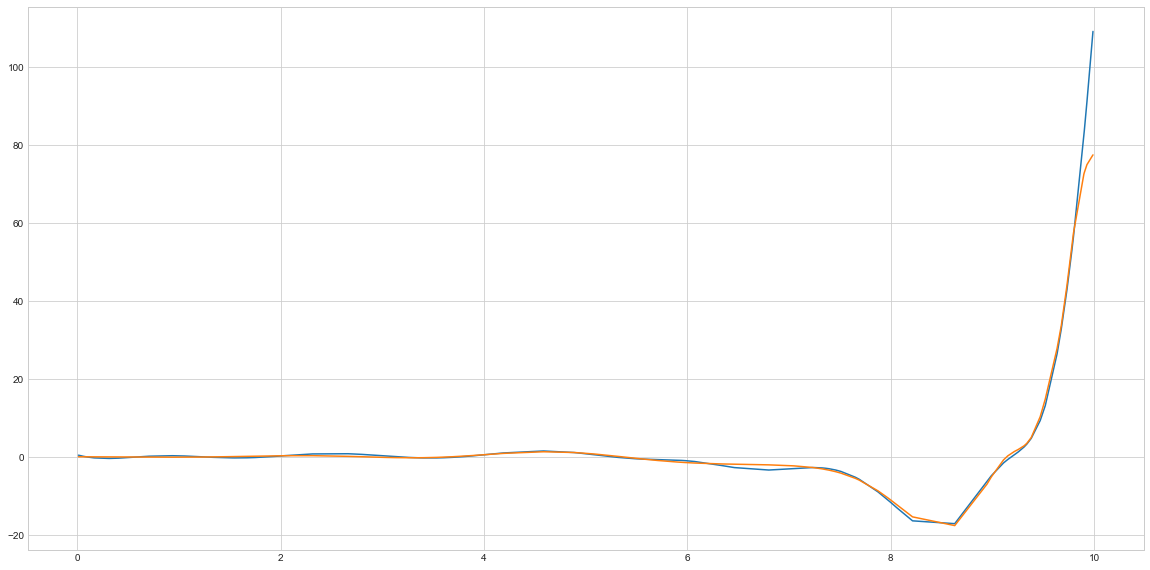

12.57667 sec


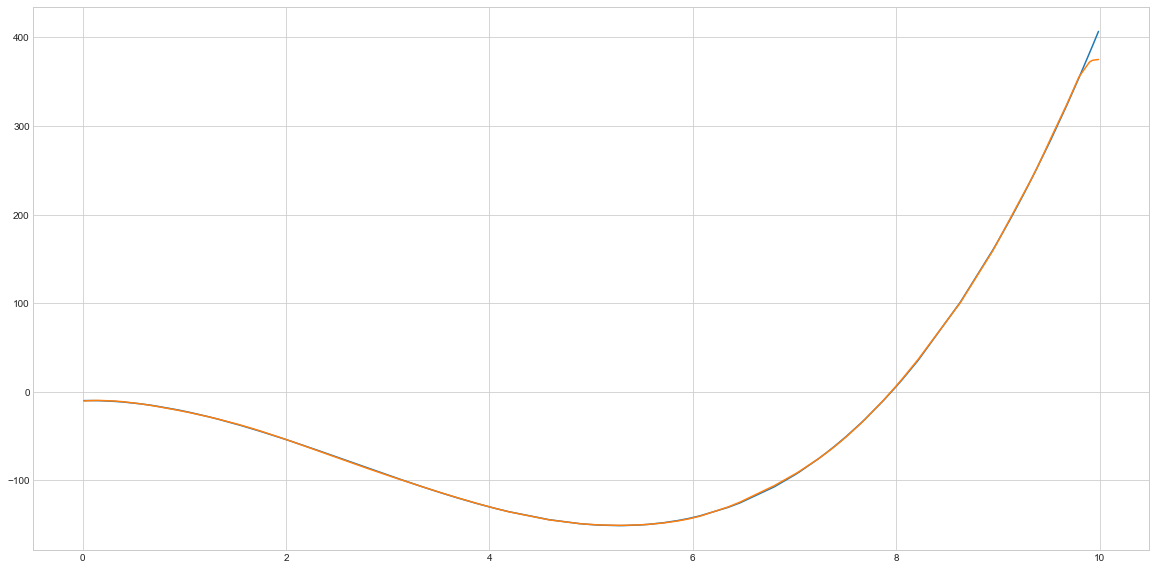

In [5]:
start = time.time()
model2 = RBF_Add(100, device)
model2.train(input_2, target3, 1000, 0.0001, 15, 1)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_2.cpu().detach().numpy(), target3[0].cpu().detach().numpy())
plt.plot(input_2.cpu().detach().numpy(), model2.pred(input_2)[1][0].cpu().detach().numpy())
rbf_grad2 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

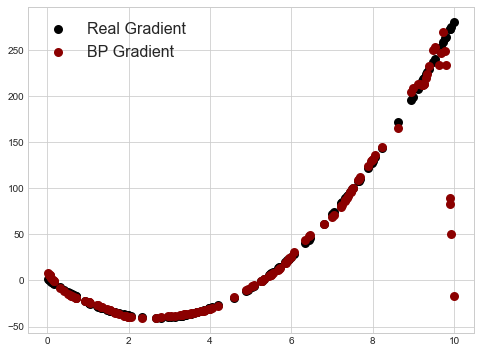

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(input_2.cpu().detach().numpy(), poly_gr.cpu().detach().numpy(),label='Real Gradient', linewidths = 3.0, color = 'black',zorder=2)
plt.scatter(input_2.cpu().detach().numpy(), rbf_grad2[0].cpu().detach().numpy(),label='BP Gradient', linewidths = 3.0, color = 'darkred',zorder=2)
plt.legend(fontsize = 16,facecolor='white',edgecolor='black',fancybox=True)
plt.show()

In [11]:
model2.done_linear_layer_weights.size()

torch.Size([1, 900])

In [106]:
class PSO_update(nn.Module):
    def __init__(self, input_data, linear_weights, centers, sigmas, device):
        super(PSO_update, self).__init__()
        
        self.input_data = input_data
        self.linear_weights = linear_weights
        self.centers = centers
        self.sigmas = sigmas
        self.device = device
        
    def rbfnn(self, weights):
        R = torch.exp(-1 * (torch.pow((self.input_data - self.centers), 2) / \
                                 (torch.pow(self.sigmas, 2))))
        output = torch.mm(weights, R)

        return output  # size = (1, num_rbf)
    
    def initial_velocity(self):
        rbf_output = (-2 * (self.input_data-self.centers) / torch.pow(self.sigmas,2)) * (torch.exp(-1 * (torch.pow((self.input_data - self.centers), 2) / (torch.pow(self.sigmas, 2)))))
        rbf_grad = torch.mm(self.linear_weights, rbf_output)
        
        return rbf_grad
    
    # fitness_function
    def cost_function(self, weights,  target): 
        pred = self.rbfnn(weights)
        error = torch.mean(torch.pow(pred - target, 2))
        
        return error
    
    def update_position(self, particle, velocity):
        new_particle = particle + velocity
        
        return new_particle
    
    def update_velocity(self, particle, velocity, pbest, gbest, lr):
         # initial velocity
        r1 = lr
        r2 = lr

        new_velocity = velocity + r1*(pbest-particle) + r2*(gbest-particle)
            
        return new_velocity
    
    def train(self, target, epochs, loss_th, lr):
        particles = torch.randn((100, self.linear_weights.size(0), self.linear_weights.size(1)), dtype = float, device = self.device)
        velocity = torch.zeros_like(particles, device = self.device)
        pbest_position = particles # (100, 1, rbf_num)
        pbest_fitness = torch.tensor([self.cost_function(particles[i], target) for i in range(100)], device= self.device)
        
        gbest_index = torch.argmin(pbest_fitness) 
        gbest = pbest_position[gbest_index].expand(100, self.linear_weights.size(0), self.linear_weights.size(1)) # (1, rbf_num)
        print(gbest.size())
        for epoch in range(epochs):
            print(epoch, end = " ")
            loss = self.cost_function(gbest[0], target)
            if  loss <= loss_th:
                break
            else:
                velocity = self.update_velocity(particles, velocity, pbest_position, gbest, lr)
                particles = self.update_position(particles, velocity)

                particle_fitness = torch.tensor([self.cost_function(particles[n], target) for n in range(100)], device= self.device)
                for n in range(100):
                    if particle_fitness[n] < pbest_fitness[n]:
                        pbest_position[n] = particles[n]
                        pbest_fitness[n] = particle_fitness[n]
                gbest_index = torch.argmin(pbest_fitness)
                gbest = pbest_position[gbest_index].expand(100, self.linear_weights.size(0), self.linear_weights.size(1))

        # Print the results
        print('Global Best Position: ', gbest)
        print('Best Fitness Value: ', min(pbest_fitness))
        print('Average Particle Best Fitness Value: ', torch.mean(pbest_fitness))
        print('Number of Generation: ', epoch)
        
        gbest[0]
        
        plt.figure(figsize=(20, 10))
        plt.plot(self.input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        plt.plot(self.input_data.cpu().detach().numpy(), self.rbfnn(gbest[0])[0].cpu().detach().numpy())
        plt.show()
        
        return gbest[0]

In [110]:
PSO = PSO_update(input_2, model2.done_linear_layer_weights, model2.done_radial_layer_centers, model2.done_radial_sigma, device)

In [111]:
model2.done_linear_layer_weights.size()

torch.Size([1, 900])

torch.Size([100, 1, 900])
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 

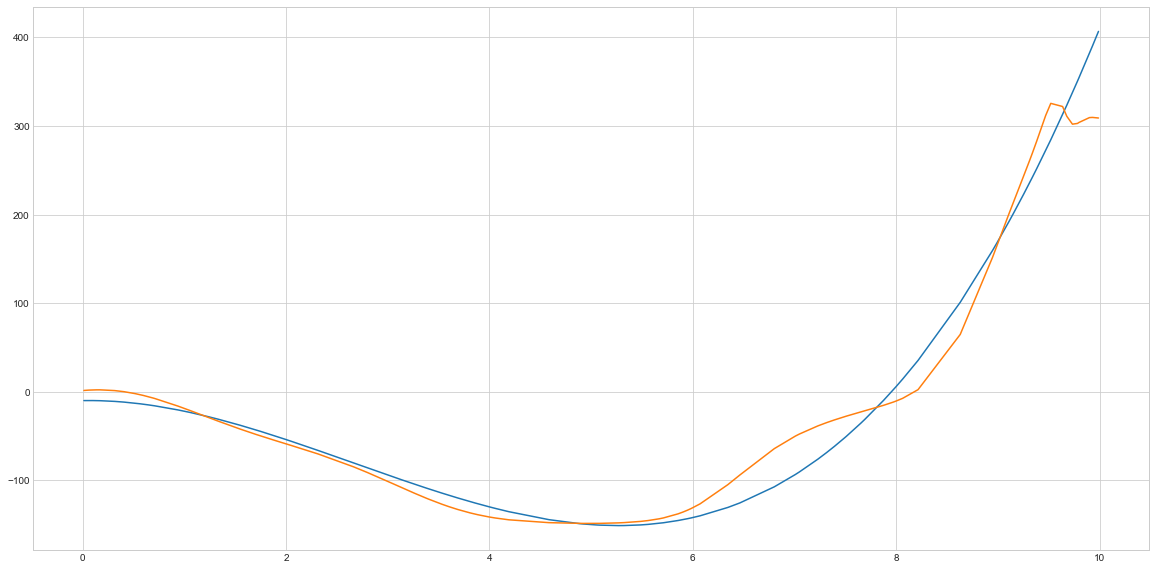

In [112]:
gbest = PSO.train(target3,1000, 5 ,0.001)

In [113]:
rbf_grad3 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, gbest)

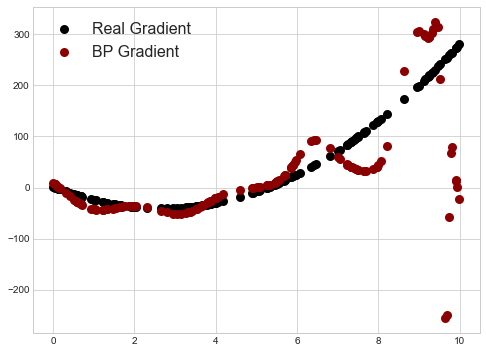

In [114]:
plt.figure(figsize=(8,6))
plt.scatter(input_2.cpu().detach().numpy(), poly_gr.cpu().detach().numpy(),label='Real Gradient', linewidths = 3.0, color = 'black',zorder=2)
plt.scatter(input_2.cpu().detach().numpy(), rbf_grad3[0].cpu().detach().numpy(),label='BP Gradient', linewidths = 3.0, color = 'darkred',zorder=2)
plt.legend(fontsize = 16,facecolor='white',edgecolor='black',fancybox=True)
plt.show()